In [1]:
import torch
from torch.backends import cudnn
from face_detection import RetinaFace
from torchvision import transforms

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from networks.sixDRepNet_networks import SixDRepNet
from utils import sixdrepnet_util

In [2]:
cudnn.enabled = True
device = torch.device('cuda:0')
snapshot_path = "/mnt/iot-qnap3/mochida/medical-care/emotionestimation/data/params/6DRepNet-snapshots/6DRepNet_300W_LP_AFLW2000.pth"
model = SixDRepNet(backbone_name='RepVGG-B1g2',
                       backbone_file='',
                       deploy=True,
                       pretrained=False)
detector = RetinaFace()
transformations = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [3]:
saved_state_dict = torch.load(snapshot_path, map_location='cpu')

if 'model_state_dict' in saved_state_dict:
    print('Loading model_state_dict.')
    model.load_state_dict(saved_state_dict['model_state_dict'])
else:
    print('Loading saved_state_dict.')
    model.load_state_dict(saved_state_dict)
    
model.to(device)

model.eval()

Loading saved_state_dict.


SixDRepNet(
  (layer0): RepVGGBlock(
    (nonlinearity): ReLU()
    (se): Identity()
    (rbr_reparam): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (layer1): Sequential(
    (0): RepVGGBlock(
      (nonlinearity): ReLU()
      (se): Identity()
      (rbr_reparam): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): RepVGGBlock(
      (nonlinearity): ReLU()
      (se): Identity()
      (rbr_reparam): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    )
    (2): RepVGGBlock(
      (nonlinearity): ReLU()
      (se): Identity()
      (rbr_reparam): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): RepVGGBlock(
      (nonlinearity): ReLU()
      (se): Identity()
      (rbr_reparam): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    )
  )
  (layer2): Sequential(
    (0): RepVGGBlock(
      (nonlinearity): ReLU()
      (se): Identity()
      

Pitch: -10.6904296875, Yaw: 4.493285179138184, Roll: -0.5719847679138184


(-0.5, 255.5, 255.5, -0.5)

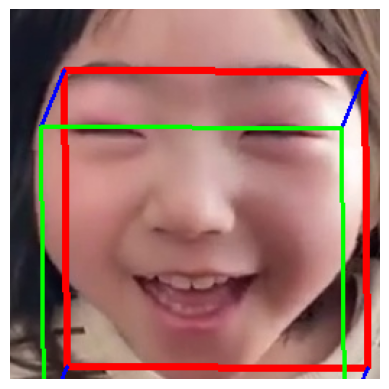

In [6]:
video_name = 'video16'
frame_num = 530
frame_num = str(frame_num).zfill(4)

img_path = f"/mnt/iot-qnap3/mochida/medical-care/emotionestimation/data/interim/PIMD_A/{video_name}/{video_name}_{frame_num}.jpg"
frame = cv2.imread(img_path)

faces = detector(frame)

for box, landmarks, score in faces:

    # Print the location of each face in this image
    if score < .95:
        continue
    x_min = int(box[0])
    y_min = int(box[1])
    x_max = int(box[2])
    y_max = int(box[3])
    bbox_width = abs(x_max - x_min)
    bbox_height = abs(y_max - y_min)

    x_min = max(0, x_min-int(0.2*bbox_height))
    y_min = max(0, y_min-int(0.2*bbox_width))
    x_max = x_max+int(0.2*bbox_height)
    y_max = y_max+int(0.2*bbox_width)

    img = frame[y_min:y_max, x_min:x_max]
    img = Image.fromarray(img)
    img = img.convert('RGB')
    img = transformations(img)
    img = img.unsqueeze(0).to(device)

R_pred, _, logits = model(img)
euler = sixdrepnet_util.compute_euler_angles_from_rotation_matrices(R_pred)*180/np.pi
p_pred_deg = euler[:, 0].cpu()
y_pred_deg = euler[:, 1].cpu()
r_pred_deg = euler[:, 2].cpu()

# tensor to float
p_pred_deg = p_pred_deg.detach().numpy()
y_pred_deg = y_pred_deg.detach().numpy()
r_pred_deg = r_pred_deg.detach().numpy()

# sixdrepnet_util.draw_axis(frame, y_pred_deg, p_pred_deg, r_pred_deg, x_min+int(.5*(x_max-x_min))-10, y_min+int(.5*(y_max-y_min))-10, size=100)
sixdrepnet_util.plot_pose_cube(frame,  y_pred_deg, p_pred_deg, r_pred_deg, x_min + int(.5*(x_max-x_min)), y_min + int(.5*(y_max-y_min)), size=bbox_width)
print(f"Pitch: {p_pred_deg[0]}, Yaw: {y_pred_deg[0]}, Roll: {r_pred_deg[0]}")
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.axis('off')